## MTA Subway Data Analysis (Project 1)    
  
Daniel Kim  
Gregory Marx  
D'Frantz Smart  

### Column information 

* **C/A**      = Control Area (A002)
* **UNIT**     = Remote Unit for a station (R051)
* **SCP**      = Subunit Channel Position represents an specific address for a device (02-00-00)
* **STATION**  = Represents the station name the device is located at
* **LINENAME** = Represents all train lines that can be boarded at this station
     * Normally lines are represented by one character.  LINENAME 456NQR repersents train server for 4, 5, 6, N, Q, and R trains)
* **DIVISION** = Represents the Line originally the station belonged to BMT, IRT, or IND   
* **DATE**     = Represents the date (MM-DD-YY)
* **TIME**     = Represents the time (hh:mm:ss) for a scheduled audit event
* **DESc**     = Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)
     * Audits may occur more that 4 hours due to planning, or troubleshooting activities. 
     * Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered. 
     
* **ENTRIES**  = The comulative entry register value for a device
* **The EXIST**    = The cumulative exit register value for a device

## Loading data

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import dateutil.parser
import seaborn as sns
import pickle
import random

# You can configure the format of the images: ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%config InlineBackend.figure_format = 'jpeg'
%matplotlib inline

In [2]:
# Obtain data from first two weeks of October from 2016 to 2018
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [161001,161008,171007,171014,181006,181013]
df = get_data(week_nums)

In [3]:
print(df.shape)
df.head()

(1179399, 11)


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456,BMT,09/24/2016,00:00:00,REGULAR,5838478,1979173
1,A002,R051,02-00-00,59 ST,NQR456,BMT,09/24/2016,04:00:00,REGULAR,5838515,1979180
2,A002,R051,02-00-00,59 ST,NQR456,BMT,09/24/2016,08:00:00,REGULAR,5838530,1979220
3,A002,R051,02-00-00,59 ST,NQR456,BMT,09/24/2016,12:00:00,REGULAR,5838635,1979322
4,A002,R051,02-00-00,59 ST,NQR456,BMT,09/24/2016,16:00:00,REGULAR,5838951,1979397


## Preprocessing

In [4]:
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [5]:
# Remove space in columns
df.columns = [column.strip() for column in df.columns]
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [6]:
# Create new column DATETIME in a time series
df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, format="%m/%d/%Y %H:%M:%S")

In [7]:
# Filter REGULAR
df=df.loc[df["DESC"] == "REGULAR"]
print(df.shape)
df.head()

(1174953, 12)


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456,BMT,09/24/2016,00:00:00,REGULAR,5838478,1979173,2016-09-24 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456,BMT,09/24/2016,04:00:00,REGULAR,5838515,1979180,2016-09-24 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456,BMT,09/24/2016,08:00:00,REGULAR,5838530,1979220,2016-09-24 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456,BMT,09/24/2016,12:00:00,REGULAR,5838635,1979322,2016-09-24 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456,BMT,09/24/2016,16:00:00,REGULAR,5838951,1979397,2016-09-24 16:00:00


In [8]:
# Find number of missing values
df.isna().sum()

C/A          0
UNIT         0
SCP          0
STATION      0
LINENAME     0
DIVISION     0
DATE         0
TIME         0
DESC         0
ENTRIES      0
EXITS        0
DATE_TIME    0
dtype: int64

In [9]:
# Check duplicates
(df
.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE", "TIME"])
.ENTRIES.count()
.reset_index()
.sort_values("ENTRIES", ascending=False)).head()

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,09/24/2016,00:00:00,1
783299,R147,R033,04-05-00,TIMES SQ-42 ST,10/01/2017,20:00:00,1
783305,R147,R033,04-05-00,TIMES SQ-42 ST,10/01/2018,20:00:00,1
783304,R147,R033,04-05-00,TIMES SQ-42 ST,10/01/2018,16:00:00,1
783303,R147,R033,04-05-00,TIMES SQ-42 ST,10/01/2018,12:00:00,1


In [10]:
# Create year, month, day, hour columns
df["year"] = df["DATE_TIME"].dt.year
df["day"] = df["DATE_TIME"].dt.day
df["hour"] = df["DATE_TIME"].dt.hour


# 0(MONDAY), 1(TUESDAY), 2(WEDNESDAY), 3(THURSDAY), 4(FRIDAY), 5(SATURDAY), 6(SUNDAY)
# Change day of week to previous day for 0 hour because "hour" indicates end of a time interval 
df["dayofweek"] = [x.dayofweek if x.hour != 0 else (x.dayofweek-1)%7 for x in df["DATE_TIME"]]
# print (row, column)
print(df.shape)

# DATE_TIME and rest of columns
df[["DATE_TIME", "year", "day", "hour", "dayofweek"]].head()

(1174953, 16)


,DATE_TIME,year,day,hour,dayofweek
0,2016-09-24 00:00:00,2016,24,0,4
1,2016-09-24 04:00:00,2016,24,4,5
2,2016-09-24 08:00:00,2016,24,8,5
3,2016-09-24 12:00:00,2016,24,12,5
4,2016-09-24 16:00:00,2016,24,16,5


In [11]:
# Change dayofweek to(Monday ~ Sunday)
# Create new column of dayofweek(humanized)and store(Monday ~ Sunday)
df.loc[df["dayofweek"] == 0, "dayofweek(humanized)"] = "Mon"
df.loc[df["dayofweek"] == 1, "dayofweek(humanized)"] = "Tue"
df.loc[df["dayofweek"] == 2, "dayofweek(humanized)"] = "Wed"
df.loc[df["dayofweek"] == 3, "dayofweek(humanized)"] = "Thurs"
df.loc[df["dayofweek"] == 4, "dayofweek(humanized)"] = "Fri"
df.loc[df["dayofweek"] == 5, "dayofweek(humanized)"] = "Sat"
df.loc[df["dayofweek"] == 6, "dayofweek(humanized)"] = "Sun"

print(df.shape)

# DATE_TIME, dayofweek, and dayofweek(humanized) columns
df[["DATE_TIME", "dayofweek", "dayofweek(humanized)"]].head()

(1174953, 17)


,DATE_TIME,dayofweek,dayofweek(humanized)
0,2016-09-24 00:00:00,4,Fri
1,2016-09-24 04:00:00,5,Sat
2,2016-09-24 08:00:00,5,Sat
3,2016-09-24 12:00:00,5,Sat
4,2016-09-24 16:00:00,5,Sat


In [12]:
# Create previous date_time, previous entries, and previous exits columns
df[["PREV_DATE_TIME", "PREV_ENTRIES","PREV_EXITS"]] = (df
                                     .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE_TIME", "ENTRIES", "EXITS"]
                                     .transform(lambda grp: grp.shift(1)))

In [13]:
print(df.shape)
df.head()

(1174953, 20)


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,year,day,hour,dayofweek,dayofweek(humanized),PREV_DATE_TIME,PREV_ENTRIES,PREV_EXITS
0,A002,R051,02-00-00,59 ST,NQR456,BMT,09/24/2016,00:00:00,REGULAR,5838478,1979173,2016-09-24 00:00:00,2016,24,0,4,Fri,NaT,NaN,NaN
1,A002,R051,02-00-00,59 ST,NQR456,BMT,09/24/2016,04:00:00,REGULAR,5838515,1979180,2016-09-24 04:00:00,2016,24,4,5,Sat,2016-09-24 00:00:00,5838478.0,1979173.0
2,A002,R051,02-00-00,59 ST,NQR456,BMT,09/24/2016,08:00:00,REGULAR,5838530,1979220,2016-09-24 08:00:00,2016,24,8,5,Sat,2016-09-24 04:00:00,5838515.0,1979180.0
3,A002,R051,02-00-00,59 ST,NQR456,BMT,09/24/2016,12:00:00,REGULAR,5838635,1979322,2016-09-24 12:00:00,2016,24,12,5,Sat,2016-09-24 08:00:00,5838530.0,1979220.0
4,A002,R051,02-00-00,59 ST,NQR456,BMT,09/24/2016,16:00:00,REGULAR,5838951,1979397,2016-09-24 16:00:00,2016,24,16,5,Sat,2016-09-24 12:00:00,5838635.0,1979322.0


Dealing with negative values when calculating entries/exits:
In the data, we saw that several machines were configured to count entries and exits down rather than up. As long as the values were of appropriate magnitude, we kept the data and took the absolute value. 

In [14]:
# Calculate difference, take absolute value, and sum to get total traffic
df["ENTRIES_DIFFERENCE"]=abs(df["ENTRIES"]-df["PREV_ENTRIES"])
df["EXITS_DIFFERENCE"]=abs(df["EXITS"]-df["PREV_EXITS"])
df["TOTAL_TRAFFIC"]=df["ENTRIES_DIFFERENCE"]+df["EXITS_DIFFERENCE"]

In [15]:
# We want to keep track of the time interval to do analysis of time of high traffic times
# Clearly, most of the measurements occur in 4h intervals
df["TIME_INTERVAL"]=df["DATE_TIME"]-df["PREV_DATE_TIME"]
df.TIME_INTERVAL.value_counts().head()

0 days 04:00:00      1063442
0 days 04:12:00        66547
350 days 04:00:00       4205
357 days 04:00:00       4203
0 days 08:00:00         2787
Name: TIME_INTERVAL, dtype: int64

In [16]:
# Filter total traffic data less than 15,000.
# We found such large values to be the result of resets in the counter
# most of the time.
df=df.loc[df["TOTAL_TRAFFIC"]<15000]

In [17]:
print(df.shape)
df.head()

(1161612, 24)


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,...,hour,dayofweek,dayofweek(humanized),PREV_DATE_TIME,PREV_ENTRIES,PREV_EXITS,ENTRIES_DIFFERENCE,EXITS_DIFFERENCE,TOTAL_TRAFFIC,TIME_INTERVAL
1,A002,R051,02-00-00,59 ST,NQR456,BMT,09/24/2016,04:00:00,REGULAR,5838515,...,4,5,Sat,2016-09-24 00:00:00,5838478.0,1979173.0,37.0,7.0,44.0,04:00:00
2,A002,R051,02-00-00,59 ST,NQR456,BMT,09/24/2016,08:00:00,REGULAR,5838530,...,8,5,Sat,2016-09-24 04:00:00,5838515.0,1979180.0,15.0,40.0,55.0,04:00:00
3,A002,R051,02-00-00,59 ST,NQR456,BMT,09/24/2016,12:00:00,REGULAR,5838635,...,12,5,Sat,2016-09-24 08:00:00,5838530.0,1979220.0,105.0,102.0,207.0,04:00:00
4,A002,R051,02-00-00,59 ST,NQR456,BMT,09/24/2016,16:00:00,REGULAR,5838951,...,16,5,Sat,2016-09-24 12:00:00,5838635.0,1979322.0,316.0,75.0,391.0,04:00:00
5,A002,R051,02-00-00,59 ST,NQR456,BMT,09/24/2016,20:00:00,REGULAR,5839333,...,20,5,Sat,2016-09-24 16:00:00,5838951.0,1979397.0,382.0,65.0,447.0,04:00:00


## Exploring Data

In [18]:
# Groupby stations to see total traffic
top_ten=df.groupby(["STATION"]).TOTAL_TRAFFIC.sum().nlargest(10).index
list(top_ten)

['34 ST-PENN STA',
 'GRD CNTRL-42 ST',
 '34 ST-HERALD SQ',
 '14 ST-UNION SQ',
 '23 ST',
 'TIMES SQ-42 ST',
 '42 ST-PORT AUTH',
 'FULTON ST',
 '86 ST',
 '125 ST']

In [19]:
df_top=df[df.STATION.isin(top_ten)]
df_top.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,...,hour,dayofweek,dayofweek(humanized),PREV_DATE_TIME,PREV_ENTRIES,PREV_EXITS,ENTRIES_DIFFERENCE,EXITS_DIFFERENCE,TOTAL_TRAFFIC,TIME_INTERVAL
2647,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237,BMT,09/24/2016,04:00:00,REGULAR,6058120,...,4,5,Sat,2016-09-24 00:00:00,6058042.0,7096131.0,78.0,53.0,131.0,04:00:00
2648,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237,BMT,09/24/2016,08:00:00,REGULAR,6058196,...,8,5,Sat,2016-09-24 04:00:00,6058120.0,7096184.0,76.0,119.0,195.0,04:00:00
2649,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237,BMT,09/24/2016,12:00:00,REGULAR,6058411,...,12,5,Sat,2016-09-24 08:00:00,6058196.0,7096303.0,215.0,452.0,667.0,04:00:00
2650,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237,BMT,09/24/2016,16:00:00,REGULAR,6058735,...,16,5,Sat,2016-09-24 12:00:00,6058411.0,7096755.0,324.0,527.0,851.0,04:00:00
2651,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237,BMT,09/24/2016,20:00:00,REGULAR,6059156,...,20,5,Sat,2016-09-24 16:00:00,6058735.0,7097282.0,421.0,528.0,949.0,04:00:00


In [20]:
# Change column names
df_top=df_top.replace('34 ST-PENN STA','Penn(34th)')
df_top=df_top.replace('GRD CNTRL-42 ST','Grand Central(42th)')
df_top=df_top.replace('34 ST-HERALD SQ','Herald SQ(34th)')
df_top=df_top.replace('14 ST-UNION SQ','Union SQ(14th)')
df_top=df_top.replace('23 ST','23 St.')
df_top=df_top.replace('TIMES SQ-42 ST','Time SQ(42th)')
df_top=df_top.replace('42 ST-PORT AUTH','Ports Authority(42th)')
df_top=df_top.replace('FULTON ST','Fulton St.')
df_top=df_top.replace('86 ST','86 St.')
df_top=df_top.replace('125 ST','125 St.')

In [21]:
station_total_traffic=df_top.groupby(["STATION"]).TOTAL_TRAFFIC.sum().sort_values(ascending=False).reset_index()
station_total_traffic

,STATION,TOTAL_TRAFFIC
0,Penn(34th),11684665.0
1,Grand Central(42th),10399217.0
2,Herald SQ(34th),8509434.0
3,Union SQ(14th),7529231.0
4,23 St.,7398502.0
5,Time SQ(42th),7360336.0
6,Ports Authority(42th),6640732.0
7,Fulton St.,6446852.0
8,86 St.,6310066.0
9,125 St.,5454784.0


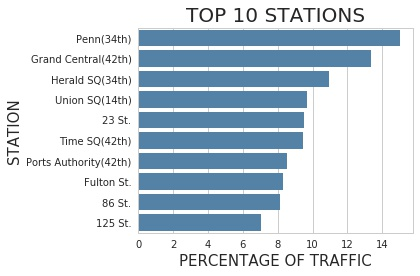

In [22]:
# Plot percentage of trafficd vs. Station for top 10 stations

sns.set(style="whitegrid")
sns.barplot(y=station_total_traffic["STATION"],
            x=(station_total_traffic["TOTAL_TRAFFIC"])/sum(station_total_traffic["TOTAL_TRAFFIC"])*100,
            color="steelblue")
plt.title('TOP 10 STATIONS',fontsize = 20);
plt.ylabel("STATION",fontsize=15)
plt.xlabel("PERCENTAGE OF TRAFFIC",fontsize=15)
plt.tight_layout()
plt.savefig('Top10_stations.png',format='png',dpi=500)

In [23]:
year_total_traffic=df_top.groupby(["year"]).TOTAL_TRAFFIC.sum().reset_index()
year_total_traffic

,year,TOTAL_TRAFFIC
0,2016,26173847.0
1,2017,25675840.0
2,2018,25884132.0


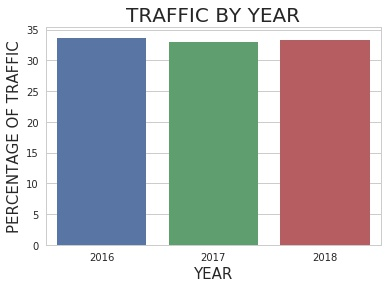

In [24]:
# Plot total traffic vs. year
sns.barplot(x=year_total_traffic["year"], y=(year_total_traffic["TOTAL_TRAFFIC"])
            /sum(year_total_traffic["TOTAL_TRAFFIC"])*100)
plt.ylabel('PERCENTAGE OF TRAFFIC',fontsize=15)
plt.xlabel('YEAR',fontsize=15)
plt.title('TRAFFIC BY YEAR',fontsize=20)
plt.savefig('Traffic_year.png',format='png',dpi=500)

In [25]:
day_total_traffic=df_top.groupby(["dayofweek(humanized)"]).TOTAL_TRAFFIC.sum().reset_index()
day_total_traffic

,dayofweek(humanized),TOTAL_TRAFFIC
0,Fri,12894605.0
1,Mon,11547319.0
2,Sat,7321902.0
3,Sun,6082299.0
4,Thurs,13529266.0
5,Tue,12951862.0
6,Wed,13406566.0


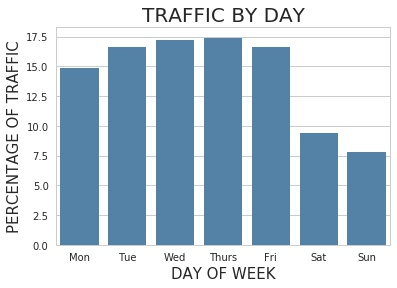

In [26]:
# Plot percentage of traffic vs. day
sns.barplot(x=day_total_traffic["dayofweek(humanized)"], y=(day_total_traffic["TOTAL_TRAFFIC"])
            /sum(day_total_traffic["TOTAL_TRAFFIC"])*100,
            color ="steelblue",
            order=['Mon','Tue','Wed','Thurs','Fri','Sat','Sun'],
            ci=None)

plt.ylabel('PERCENTAGE OF TRAFFIC',fontsize=15)
plt.xlabel('DAY OF WEEK',fontsize=15)
plt.title('TRAFFIC BY DAY',fontsize=20)
plt.savefig('Traffic_day.png',format='png',dpi=500)

In [27]:
# define functin to store traffic into 4 hour intervals
# Most of the data in the top ten has data readings at the hours 0,4,8,12,...,20. Some have readings inbetween which
# we can handle. The notable exception is 14 "ST-UNION SQ" which has readings at 1,5,9,... and does not regularly take 
# readings at the normal hours mentioned before. The function below will assign these values and others which don't fit 
# our binning scheme as np.NaN

# high=ending hour
# low = start hour
# interval = interval between readings

def time_bin(low, high, interval):
    if interval > dt.timedelta(hours=4):
        return np.NaN
    elif 0<=low<high<=4:
        return "0-4"
    elif 4<=low<high<=8:
        return "4-8"
    elif 8<=low<high<=12:
        return "8-12"
    elif 12<=low<high<=16:
        return "12-16"
    elif 16<=low<high<=20:
        return "16-20"
    elif (20<=low<high<=24) or (20<=low<24 and high == 0):
        return '20-24'
    else:
        return np.NaN

In [28]:
# Create time interval column
df_top["TIME_BIN"]=[time_bin(low,high,interval) for low,high,interval 
                             in zip(df_top.PREV_DATE_TIME.dt.hour, df_top.DATE_TIME.dt.hour, df_top.TIME_INTERVAL)]
df_top.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,...,dayofweek,dayofweek(humanized),PREV_DATE_TIME,PREV_ENTRIES,PREV_EXITS,ENTRIES_DIFFERENCE,EXITS_DIFFERENCE,TOTAL_TRAFFIC,TIME_INTERVAL,TIME_BIN
2647,A021,R032,01-00-00,Time SQ(42th),ACENQRS1237,BMT,09/24/2016,04:00:00,REGULAR,6058120,...,5,Sat,2016-09-24 00:00:00,6058042.0,7096131.0,78.0,53.0,131.0,04:00:00,0-4
2648,A021,R032,01-00-00,Time SQ(42th),ACENQRS1237,BMT,09/24/2016,08:00:00,REGULAR,6058196,...,5,Sat,2016-09-24 04:00:00,6058120.0,7096184.0,76.0,119.0,195.0,04:00:00,4-8
2649,A021,R032,01-00-00,Time SQ(42th),ACENQRS1237,BMT,09/24/2016,12:00:00,REGULAR,6058411,...,5,Sat,2016-09-24 08:00:00,6058196.0,7096303.0,215.0,452.0,667.0,04:00:00,8-12
2650,A021,R032,01-00-00,Time SQ(42th),ACENQRS1237,BMT,09/24/2016,16:00:00,REGULAR,6058735,...,5,Sat,2016-09-24 12:00:00,6058411.0,7096755.0,324.0,527.0,851.0,04:00:00,12-16
2651,A021,R032,01-00-00,Time SQ(42th),ACENQRS1237,BMT,09/24/2016,20:00:00,REGULAR,6059156,...,5,Sat,2016-09-24 16:00:00,6058735.0,7097282.0,421.0,528.0,949.0,04:00:00,16-20


In [29]:
time_bin_traffic=df_top.groupby(["TIME_BIN"]).TOTAL_TRAFFIC.sum().reset_index()
time_bin_traffic

,TIME_BIN,TOTAL_TRAFFIC
0,0-4,844134.0
1,12-16,9178218.0
2,16-20,15126207.0
3,20-24,4995029.0
4,4-8,4216734.0
5,8-12,11118992.0


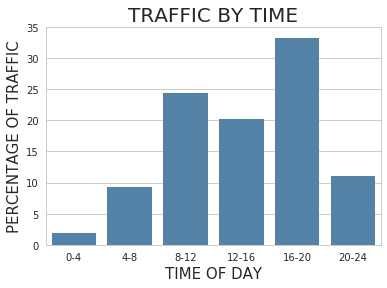

In [30]:
sns.barplot(x=time_bin_traffic["TIME_BIN"], 
            y=(time_bin_traffic["TOTAL_TRAFFIC"])/sum(time_bin_traffic["TOTAL_TRAFFIC"])*100,
            color ="steelblue",
            order=['0-4','4-8','8-12','12-16','16-20','20-24'],
            ci=None)
plt.ylabel('PERCENTAGE OF TRAFFIC',fontsize=15)
plt.xlabel('TIME OF DAY',fontsize=15)
plt.title('TRAFFIC BY TIME',fontsize=20)
plt.savefig('Traffic_hour.png',format='png',dpi=500)

In [31]:
# Make separate data for weekend
df_weekend = df_top[(df_top["dayofweek(humanized)"]=="Sun") |
               (df_top["dayofweek(humanized)"]=="Sat")]

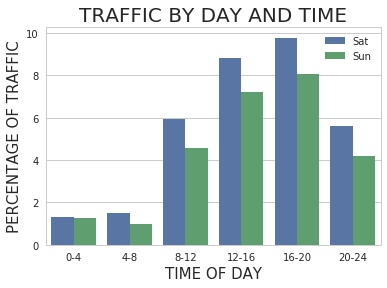

In [32]:
# Plot total traffic for weekend
sns.barplot(x=df_weekend["TIME_BIN"], 
            y=(df_weekend["TOTAL_TRAFFIC"])
            /sum(df_weekend["TOTAL_TRAFFIC"])*100,
            estimator=sum,hue=df_weekend['dayofweek(humanized)'],
            order=['0-4','4-8','8-12','12-16','16-20','20-24'],
            ci=None)
plt.title('TRAFFIC BY DAY AND TIME',fontsize = 20);
plt.xlabel("TIME OF DAY",fontsize=15)
plt.ylabel("PERCENTAGE OF TRAFFIC",fontsize=15)
plt.legend(title="")
plt.savefig('Traffic_weekend.png',format='png',dpi=500)